## Section 1 — Connect to DB & Load Alerts:

Description: Loads the local database and retrieves recent alerts to identify suspicious wallets for investigation.

In [1]:
import sqlite3
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

BASE_DIR = Path.cwd().parents[0]
DB_PATH = BASE_DIR / "db" / "crypto_fraud.db"

conn = sqlite3.connect(DB_PATH)

df_alerts = pd.read_sql_query(
    """
    SELECT
      wallet_id,
      kpi_name,
      chain,
      details,
      created_at
    FROM alerts
    ORDER BY created_at DESC
    """,
    conn,
)

df_alerts.head(10)


,wallet_id,kpi_name,chain,details,created_at
0,0x46340b20830761efd32832a74d7169b29feb9758,WHALE_FAN_OUT_BURST,ethereum,"distinct_recipients=8, total_outflow_usd=2657....",2025-12-27T11:31:24.699570Z
1,0xa1abfa21f80ecf401bd41365adbb6fef6fefdf09,WHALE_FAN_OUT_BURST,ethereum,"distinct_recipients=10, total_outflow_usd=4047...",2025-12-27T11:31:24.699570Z
2,0xa9ac43f5b5e38155a288d1a01d2cbc4478e14573,WHALE_FAN_OUT_BURST,ethereum,"distinct_recipients=5, total_outflow_usd=1122....",2025-12-27T11:31:24.699570Z
3,0x46340b20830761efd32832a74d7169b29feb9758,WHALE_FAN_OUT_BURST,ethereum,"distinct_recipients=8, total_outflow_usd=2657....",2025-12-27T11:30:56.881312Z
4,0xa1abfa21f80ecf401bd41365adbb6fef6fefdf09,WHALE_FAN_OUT_BURST,ethereum,"distinct_recipients=10, total_outflow_usd=4047...",2025-12-27T11:30:56.881312Z
5,0xa9ac43f5b5e38155a288d1a01d2cbc4478e14573,WHALE_FAN_OUT_BURST,ethereum,"distinct_recipients=5, total_outflow_usd=1122....",2025-12-27T11:30:56.881312Z
6,1HaT9qSGL6XycatsPp5zaKRfBGJe5vUtfo,HIGH_FAN_IN_VELOCITY,bitcoin,"distinct_senders=6, total_inflow_usd=515700.00...",2025-12-27T11:26:14.823538Z
7,0x18604f3aad07fc61b7c8b8fa1bb6d60ac6aee0b8,HIGH_FAN_IN_VELOCITY,ethereum,"distinct_senders=11, total_inflow_usd=826.64, ...",2025-12-27T11:26:14.819760Z
8,0x3328f7f4a1d1c57c35df56bbf0c9dcafca309c49,HIGH_FAN_IN_VELOCITY,ethereum,"distinct_senders=20, total_inflow_usd=5909.81,...",2025-12-27T11:26:14.819760Z
9,0x3a09c40f8f7b93c8c7e09a5422e56dfe7c7d2794,HIGH_FAN_IN_VELOCITY,ethereum,"distinct_senders=4, total_inflow_usd=7631.63, ...",2025-12-27T11:26:14.819760Z


## Section 2 — Pick Wallet to Investigate:

Selects a specific wallet from the ranked list to become the focus of the investigation.
Ranks wallets by number of alerts to surface the most suspicious and high-risk wallets.

In [2]:
suspicious_wallets = (
    df_alerts.groupby("wallet_id").size().reset_index(name="alerts_count")
    .sort_values("alerts_count", ascending=False)
)

suspicious_wallets.head(10)


,wallet_id,alerts_count
3,0x46340b20830761efd32832a74d7169b29feb9758,2
10,0xa9ac43f5b5e38155a288d1a01d2cbc4478e14573,2
9,0xa1abfa21f80ecf401bd41365adbb6fef6fefdf09,2
0,0x18604f3aad07fc61b7c8b8fa1bb6d60ac6aee0b8,1
1,0x3328f7f4a1d1c57c35df56bbf0c9dcafca309c49,1
5,0x5866ef6df11409134170f4fc84843ce2f1ee226e,1
6,0x681f537842609da902ad3e71b140bf93975b1c69,1
2,0x3a09c40f8f7b93c8c7e09a5422e56dfe7c7d2794,1
4,0x53c85c8f2abcace0430461b9d33e9950efd32d82,1
8,0x974caa59e49682cda0ad2bbe82983419a2ecc400,1


In [10]:
WALLET = suspicious_wallets.iloc[0]["wallet_id"]
WALLET


'0x46340b20830761efd32832a74d7169b29feb9758'

## Section 3 — Load Wallet Transactions:

Description: Loads all transactions involving the selected wallet — both incoming and outgoing.

In [11]:
df_tx = pd.read_sql_query(
    """
    SELECT
      tx_hash,
      block_timestamp,
      from_wallet_id,
      to_wallet_id,
      amount_usd,
      chain
    FROM transactions
    WHERE from_wallet_id = ?
       OR to_wallet_id = ?
    ORDER BY block_timestamp
    """,
    conn,
    params=(WALLET, WALLET),
)

df_tx.head(10)


,tx_hash,block_timestamp,from_wallet_id,to_wallet_id,amount_usd,chain
0,0x254d24fa2adde080cc3ed359f419ea64187acd0f584c...,2025-11-27 10:51:59.000000 UTC,0x46340b20830761efd32832a74d7169b29feb9758,0x886d6d9f8fae022319faf3299e4932fa400bd72d,2164.270,ethereum
1,0x6f32dc6d8e7f16460b57e54b21d893061fec5664a523...,2025-11-27 14:48:23.000000 UTC,0x46340b20830761efd32832a74d7169b29feb9758,0x5a22e13b763e1553af6fb64c26e02e72364f751a,220.864,ethereum
2,0xf5a5c32c5782f95b282ca4c29ff5516d59f974914f7e...,2025-11-27 15:31:35.000000 UTC,0x46340b20830761efd32832a74d7169b29feb9758,0x7be4abf774b4a109d3b15767e0b21df67af3d68d,3038.046,ethereum
3,0xffbafec030b839debf0c2cbd036cb9fb7b2628742245...,2025-11-27 15:33:23.000000 UTC,0x46340b20830761efd32832a74d7169b29feb9758,0xb8d5b9ad00359e69149280cab556d8018f872068,773.282,ethereum
4,0x92d0baf88407338b2bde77bd798029e1cf37cd64cd79...,2025-11-27 16:26:35.000000 UTC,0x46340b20830761efd32832a74d7169b29feb9758,0x3bde30f73028142635dabd046ef27349cf9ee9c0,79.566,ethereum
5,0x823d02c195dddae18d5ede3373f2506ba0d472aaa0f4...,2025-11-27 16:46:11.000000 UTC,0x46340b20830761efd32832a74d7169b29feb9758,0x0252a77a97639bd5c62665ff25bb4904f31cb0ce,164.500,ethereum
6,0xbe88f2b849e6eae440b37cf0ab74f5a0e7206856b363...,2025-11-27 17:00:23.000000 UTC,0x46340b20830761efd32832a74d7169b29feb9758,0x9fa73ecbbd5bf3ede662d2e8bd7385144e1d20e9,373.272,ethereum
7,0xf8cf0d9ba3752b098916ddefa8d58f31131f31467c4c...,2025-11-27 17:53:59.000000 UTC,0x46340b20830761efd32832a74d7169b29feb9758,0x98581e7e122513a794126fafe2a4eb7a0df9a4d3,1308.600,ethereum
8,0x4f884d44b95545e0cc3811167ae91f1df8b6943c11d0...,2025-11-27 17:59:23.000000 UTC,0x46340b20830761efd32832a74d7169b29feb9758,0xc33906cc1fc36588043caba5909604971e25ed43,610.000,ethereum
9,0x9f15714f322848b8517cbdadecc627a94ed2a8088f40...,2025-11-27 19:50:23.000000 UTC,0x46340b20830761efd32832a74d7169b29feb9758,0x80424236f9a5347bdf17ca1ec7f85106f6d87cf2,10.204,ethereum


## Section 4 — Label Inbound vs Outbound:

Description: Classifies each transaction as inbound or outbound to understand money-flow behavior.

In [12]:
df_tx["direction"] = df_tx.apply(
    lambda r: "inbound" if r["to_wallet_id"] == WALLET else "outbound",
    axis=1
)

df_tx["amount_usd"] = df_tx["amount_usd"].astype(float)

df_tx.head(10)


,tx_hash,block_timestamp,from_wallet_id,to_wallet_id,amount_usd,chain,direction
0,0x254d24fa2adde080cc3ed359f419ea64187acd0f584c...,2025-11-27 10:51:59.000000 UTC,0x46340b20830761efd32832a74d7169b29feb9758,0x886d6d9f8fae022319faf3299e4932fa400bd72d,2164.270,ethereum,outbound
1,0x6f32dc6d8e7f16460b57e54b21d893061fec5664a523...,2025-11-27 14:48:23.000000 UTC,0x46340b20830761efd32832a74d7169b29feb9758,0x5a22e13b763e1553af6fb64c26e02e72364f751a,220.864,ethereum,outbound
2,0xf5a5c32c5782f95b282ca4c29ff5516d59f974914f7e...,2025-11-27 15:31:35.000000 UTC,0x46340b20830761efd32832a74d7169b29feb9758,0x7be4abf774b4a109d3b15767e0b21df67af3d68d,3038.046,ethereum,outbound
3,0xffbafec030b839debf0c2cbd036cb9fb7b2628742245...,2025-11-27 15:33:23.000000 UTC,0x46340b20830761efd32832a74d7169b29feb9758,0xb8d5b9ad00359e69149280cab556d8018f872068,773.282,ethereum,outbound
4,0x92d0baf88407338b2bde77bd798029e1cf37cd64cd79...,2025-11-27 16:26:35.000000 UTC,0x46340b20830761efd32832a74d7169b29feb9758,0x3bde30f73028142635dabd046ef27349cf9ee9c0,79.566,ethereum,outbound
5,0x823d02c195dddae18d5ede3373f2506ba0d472aaa0f4...,2025-11-27 16:46:11.000000 UTC,0x46340b20830761efd32832a74d7169b29feb9758,0x0252a77a97639bd5c62665ff25bb4904f31cb0ce,164.500,ethereum,outbound
6,0xbe88f2b849e6eae440b37cf0ab74f5a0e7206856b363...,2025-11-27 17:00:23.000000 UTC,0x46340b20830761efd32832a74d7169b29feb9758,0x9fa73ecbbd5bf3ede662d2e8bd7385144e1d20e9,373.272,ethereum,outbound
7,0xf8cf0d9ba3752b098916ddefa8d58f31131f31467c4c...,2025-11-27 17:53:59.000000 UTC,0x46340b20830761efd32832a74d7169b29feb9758,0x98581e7e122513a794126fafe2a4eb7a0df9a4d3,1308.600,ethereum,outbound
8,0x4f884d44b95545e0cc3811167ae91f1df8b6943c11d0...,2025-11-27 17:59:23.000000 UTC,0x46340b20830761efd32832a74d7169b29feb9758,0xc33906cc1fc36588043caba5909604971e25ed43,610.000,ethereum,outbound
9,0x9f15714f322848b8517cbdadecc627a94ed2a8088f40...,2025-11-27 19:50:23.000000 UTC,0x46340b20830761efd32832a74d7169b29feb9758,0x80424236f9a5347bdf17ca1ec7f85106f6d87cf2,10.204,ethereum,outbound


## Section 5 — Timeline Chart:

Description: Visualizes the wallet’s transaction activity over time and highlights inflow vs outflow patterns.

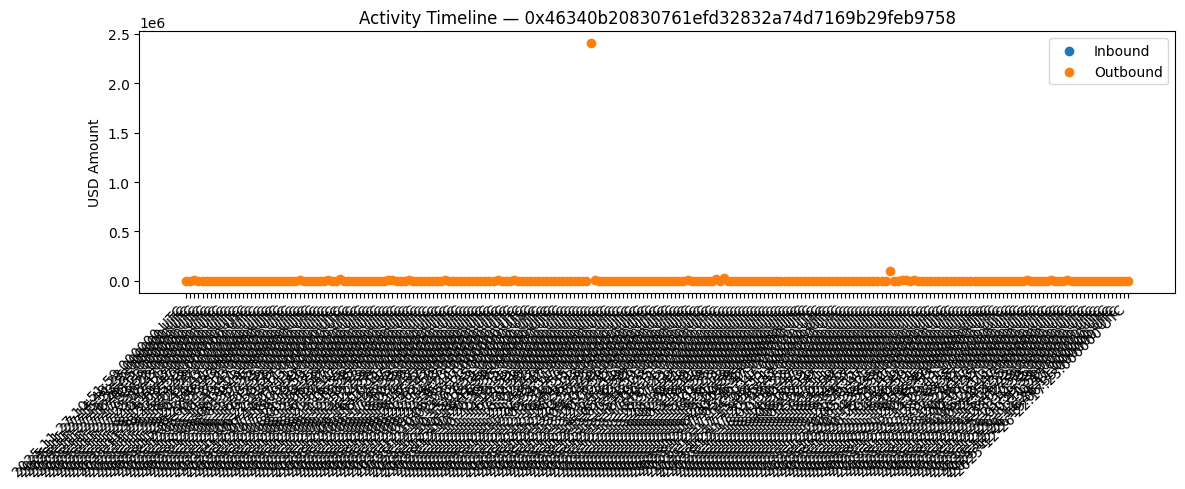

In [13]:
plt.figure(figsize=(12,5))

inbound = df_tx[df_tx["direction"] == "inbound"]
outbound = df_tx[df_tx["direction"] == "outbound"]

plt.scatter(inbound["block_timestamp"], inbound["amount_usd"], label="Inbound")
plt.scatter(outbound["block_timestamp"], outbound["amount_usd"], label="Outbound")

plt.xticks(rotation=45, ha="right")
plt.ylabel("USD Amount")
plt.title(f"Activity Timeline — {WALLET}")
plt.legend()
plt.tight_layout()
plt.show()


## Section 6 — Spike Detection:

Description: Detects abnormal high-value transactions compared to the wallet’s typical behavior.

In [14]:
suspicious_spikes = df_tx[
    (df_tx["amount_usd"] > df_tx["amount_usd"].mean() * 3)
]

suspicious_spikes


,tx_hash,block_timestamp,from_wallet_id,to_wallet_id,amount_usd,chain,direction
100,0x8a442f30d945415bda128cb02635e4ab23367254241d...,2025-12-11 17:32:59.000000 UTC,0x46340b20830761efd32832a74d7169b29feb9758,0xeae7380dd4cef6fbd1144f49e4d1e6964258a4f4,2405999.6,ethereum,outbound
174,0x01c43affe9789fe0c2460a3c1fe5c3fc83168362f5a1...,2025-12-19 15:37:11.000000 UTC,0x46340b20830761efd32832a74d7169b29feb9758,0x8bee7340304a051b16cecee05fb8c999db3b65ed,100858.8,ethereum,outbound


## Section 7 — Quick Behavioral Summary:

Description: Provides a quick behavioral profile of the wallet, including volume, flow direction, and risk signals.

In [15]:
summary = df_tx.groupby("direction")["amount_usd"].agg(["count","sum","mean"])
summary


,count,sum,mean
direction,,,
outbound,234,2.773154e+06,11851.086764
